In [7]:
from __future__ import division, print_function

import matplotlib.pyplot as plt
%matplotlib inline
import scipy.spatial as ss
import pickle
import os
import numpy as np
import random
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, RationalQuadratic, Matern
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.model_selection import learning_curve

In [8]:
data_loc = "../Data"
phys_cache = "proc_physical_3sig.pkl"
plot_loc = "../Plots"
n_neighbors = 200

In [9]:
# Load physical data
if os.path.exists(os.path.join(data_loc,phys_cache)):
    print("Reading data from cache:",phys_cache)
    with open(os.path.join(data_loc,phys_cache), 'rb') as handle:
        X, y, names = pickle.load(handle)
else:
    raise NameError("%s not defined." % phys_cache)

Reading data from cache: proc_physical_3sig.pkl


In [14]:
def kd_training(X, y, est, n_neighbors=200):
    """
    Docs
    
    Parameters
    ----------
    X : array (n_samples x n_features)
        data
    y : array (n_samples)
        target variable
    n_neighbors : int (optional)
        Number of nearest neighbors for training.  Defaults to 200
    
    Returns
    -------
    inds : list
        indicies of samples in X not used for 
    
    """
    
    # Build the kd tree for NN searching
    tree = ss.KDTree(X)
    
    # Make list of sample indicies to prevent repeating
    # inds = [x for x in range(X.shape[0])]
    inds = list(np.arange(X_train.shape[0]))
    
    # Number of fitting batches
    n_batches = int(X.shape[0]/n_neighbors)
    n_batches = X.shape[0]
    
    # make arrays to store params
    noise = np.zeros(n_batches)
    length_scale = np.zeros_like(noise)
    
    # store std
    std_list = []
    
    # Loop over fitting batches
    for ii in range(n_batches):
        # Draw random sample for fitting
        # center = random.choice(inds)
        center = ii
        
        # Find nearest neighbors for fitting
        fit_dist, fit_inds = tree.query(X[center],k=n_neighbors)
        # print(fit_inds)
        
        est.fit(X[fit_inds],y[fit_inds])
        
        # store kernel params here
        noise[ii] = est.kernel_.k1.get_params()['noise_level']
        length_scale[ii] = est.kernel_.k2.get_params()['length_scale']
        
        # store y_std
        y_pred, y_std = est.predict(X[fit_inds], return_std=True)
        std_list.append(y_std)
        
        # Remove previous samples from center consideration
        for ind in fit_inds:
            if ind in inds:
                # inds.remove(ind)
                pass
                    
    return std_list, noise, length_scale, fit_dist
# end function




def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.savefig("gp_matern.pdf")
    return plt

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

# Scale data to 0 mean, 1 std
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [19]:
# kernel = WhiteKernel() + RBF()
# kernel = WhiteKernel() + RationalQuadratic()
kernel = WhiteKernel() + Matern()


# add n_restarts_optimizer
est = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=2, random_state=42)

# std_list, noise, length_scale, dist = kd_training(X_train[:500], y_train[:500], est, n_neighbors=64)
slice = -1

est.fit(X_train[:slice], y_train[:slice])
noise = est.kernel_.k1.get_params()['noise_level']
length_scale = est.kernel_.k2.get_params()['length_scale']
y_pred, y_std = est.predict(X_train[:slice], return_std=True, return_cov=False)

/Users/mwilde/anaconda/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -1.94384554e-05,  -1.71572822e-05]), 'nit': 10, 'funcalls': 56}
  " state: %s" % convergence_dict)


<module 'matplotlib.pyplot' from '/Users/mwilde/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

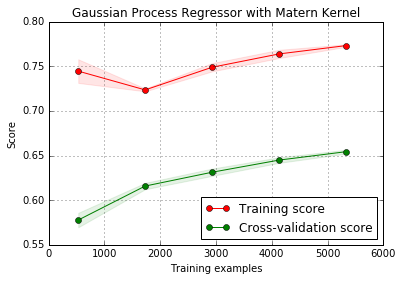

In [20]:
title = "Gaussian Process Regressor with Matern Kernel"
plot_learning_curve(est, title, X_train[:slice], y_train[:slice], ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))

In [15]:
np.median(y_std), np.median(noise), np.median(length_scale)

(0.0044720578324327839, 9.9999999999999974e-06, 6.8566786053948716)

In [ ]:
plt.hist(length_scale, 10)

In [ ]:
plt.hist(noise)

In [ ]:
plt.hist(np.median(std_list, axis=1), 10)

In [ ]:
len(np.mean(std_list, axis=1))

In [ ]:
print(kernel)
est = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=0, alpha = 0.0)

In [ ]:
est.fit(X_train, y_train)

In [ ]:
print(est.score(X_train, y_train))
print(est.score(X_test, y_test))